In [1]:
import sys
import os
sys.path = [p for p in sys.path if "ParaView" not in p]
sys.path.append("/home/haseeb/Notebooks/Parametric_DMD_cylinder_2D_modules")



import torch as pt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.tri as mtri
from flowtorch import DATASETS
from flowtorch.data import FOAMDataloader, mask_box
from pydmd import DMD, HODMD, ParametricDMD
from ezyrb import POD, Database, RBF, GPR, Linear
import seaborn as sns


from pathlib import Path
import re
# For High Quality Visuals
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 160  # crisp visuals


Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


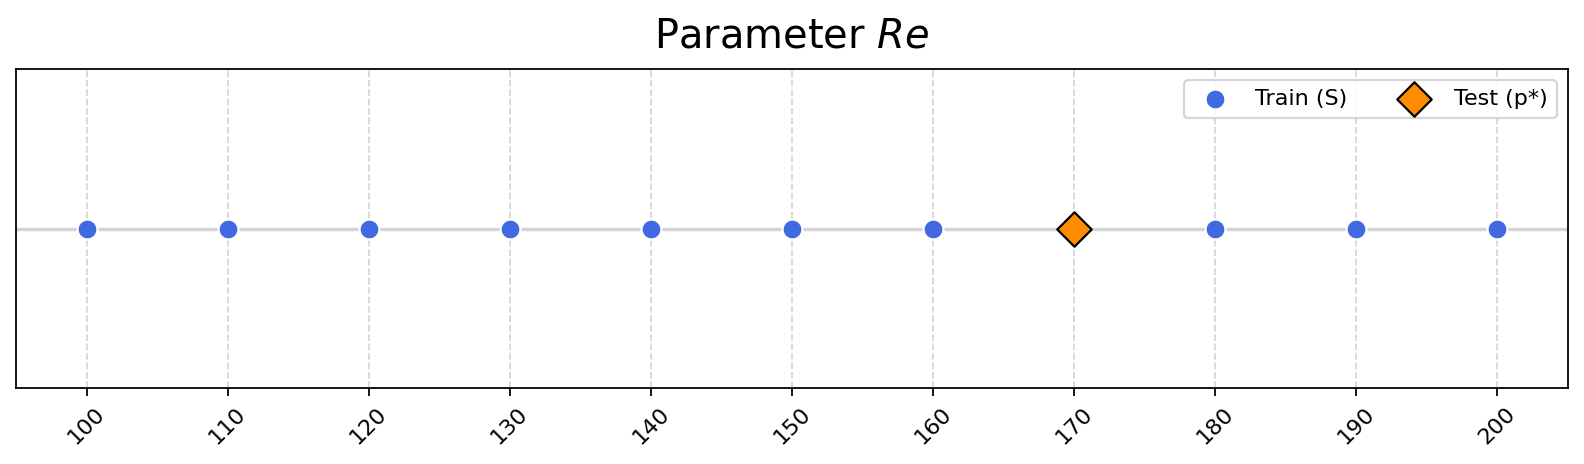

In [2]:
# Training and test parameters (parameter set P and test parameter μ*)

# Training parameter set P = {μ1, ..., μP}, i.e., Reynolds numbers
Re_list = np.array([100, 110, 120, 130, 140, 160, 150, 180, 190, 200])  # μ: training parameters

# Test parameter μ* (unseen Reynolds number)
Re_test = 170  # μ*: test parameter
# Global reference length and viscosity
L_ref = 0.1   # cylinder diameter [m]
nu = 1e-3     # kinematic viscosity [m^2/s] (example value, adjust to your case)

# Geometry parameters (from your blockMeshDict)
cylinderX = 0.2   # cylinder center x [m]
cylinderY = 0.2   # cylinder center y [m]
radius    = 0.05  # cylinder radius [m]


# Calculate reference velocities for non-dimensionalization directly from Re
U_ref_dict = {Re: Re * nu / L_ref for Re in Re_list}
U_ref_test = Re_test * nu / L_ref

# Visualization of parameter set S and test parameter p*
fig, ax = plt.subplots(figsize=(10, 3))
plt.title('Parameter $Re$', fontsize=18, pad=10)

# Plot all training parameters (S)
ax.scatter(Re_list, np.zeros_like(Re_list), 
           marker='o', s=80, color='royalblue', edgecolor='white', 
           label='Train (S)', zorder=3)

# Plot test parameter (p*)
ax.scatter(Re_test, 0, 
           marker='D', s=120, color='darkorange', edgecolor='black', 
           label='Test (p*)', zorder=4)

# Formatting
plt.xticks(np.append(Re_list, Re_test), rotation=45, fontsize=10)
plt.yticks([])
ax.axhline(0, color='lightgray', linewidth=1.5, zorder=1)   # baseline line
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend(ncols=2, frameon=True, fontsize=10)

plt.tight_layout()
plt.show()

In [3]:
# Load and prepare data

from data_loader import load_all_snapshots, load_test_parameter

# Base folder containing simulation data
base_path = os.path.expanduser("~/OpenFOAM/test_1")


# Time windows
training_window = (10.0, 15.0)  # Time range for training snapshots
future_window = (15.0, 20.0)    # Time range for future prediction
test_window = (3.0, 20.0)       # Time range for test Reynolds number

# Sampling step for downsampling time steps
sampling_step = 1

# Load training and future snapshots for all training Reynolds numbers
data = load_all_snapshots(
    Re_list=Re_list,
    base_path=base_path,
    mask_box=mask_box,
    FOAMDataloader=FOAMDataloader,
    training_window=training_window,
    future_window=future_window,
    sampling_step=sampling_step
)

# Access training data
snapshot_dict = data["snapshot_dict"]
sampled_times_dict = data["sampled_times_dict"]
snapshot_future_dict = data["snapshot_future_dict"]
sampled_times_future_dict = data["sampled_times_future_dict"]
masked_coords_dict = data["masked_coords_dict"]        
num_points_dict = data["num_points_dict"]              

# Load test snapshots for an unseen Reynolds number
path_test = f"{base_path}/cylinder_2D_Re{Re_test}"
snapshot_test, num_points_test, times_test, mask_test, coords_test, loader_test = load_test_parameter(
    Re=Re_test,
    path=path_test,
    mask_box=mask_box,
    FOAMDataloader=FOAMDataloader,
    time_window=test_window,
    sampling_step=sampling_step
)




INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor0/constant
INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor1/constant


Re=100: Masked points = 5746
Re=110: Masked points = 5746
Re=120: Masked points = 5746
Re=130: Masked points = 5746
Re=140: Masked points = 5746
Re=160: Masked points = 5746
Re=150: Masked points = 5746
Re=180: Masked points = 5746
Re=190: Masked points = 5746
Re=200: Masked points = 5746


INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor0/constant
INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor1/constant


All snapshots loaded.
Test Re=170: Loaded snapshot shape = (11492, 1701)


In [4]:
# Confirm shapes of loaded data

for Re in Re_list:
    print(f"Re={Re}, shape={snapshot_dict[Re].shape}")


Re=100, shape=(11492, 501)
Re=110, shape=(11492, 501)
Re=120, shape=(11492, 501)
Re=130, shape=(11492, 501)
Re=140, shape=(11492, 501)
Re=160, shape=(11492, 501)
Re=150, shape=(11492, 501)
Re=180, shape=(11492, 501)
Re=190, shape=(11492, 501)
Re=200, shape=(11492, 501)


## Preprocess training snapshots: Subtract mean flow

In [5]:
from preprocess_snapshots import preprocess_snapshots

# Preprocess training and test datasets

train_snapshots, mean_flow_train, snapshot_processed_dict, mean_flow_test, snapshot_test_processed = preprocess_snapshots(
    snapshot_dict=snapshot_dict,
    Re_list=Re_list,
    snapshot_test=snapshot_test,
    times_test=times_test,
    train_window=training_window
)

# Print shapes of preprocessed data
print("Training mean flow shape:", mean_flow_train.shape)
print("Test mean flow shape:", mean_flow_test.shape)
print("Training snapshot array shape:", train_snapshots.shape)

for Re in Re_list:
    print(f"Re={Re}: processed shape = {snapshot_processed_dict[Re].shape}")
    
print(f"Re={Re_test}: raw test snapshot shape = {snapshot_test.shape}")
print(f"Re={Re_test}: processed test snapshot shape = {snapshot_test_processed.shape}")

Training mean flow shape: (11492,)
Test mean flow shape: (11492,)
Training snapshot array shape: (10, 11492, 501)
Re=100: processed shape = (11492, 501)
Re=110: processed shape = (11492, 501)
Re=120: processed shape = (11492, 501)
Re=130: processed shape = (11492, 501)
Re=140: processed shape = (11492, 501)
Re=160: processed shape = (11492, 501)
Re=150: processed shape = (11492, 501)
Re=180: processed shape = (11492, 501)
Re=190: processed shape = (11492, 501)
Re=200: processed shape = (11492, 501)
Re=170: raw test snapshot shape = (11492, 1701)
Re=170: processed test snapshot shape = (11492, 501)


/home/haseeb/Notebooks/Parametric_DMD_cylinder_2D_modules/visualization_utilities.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=16)


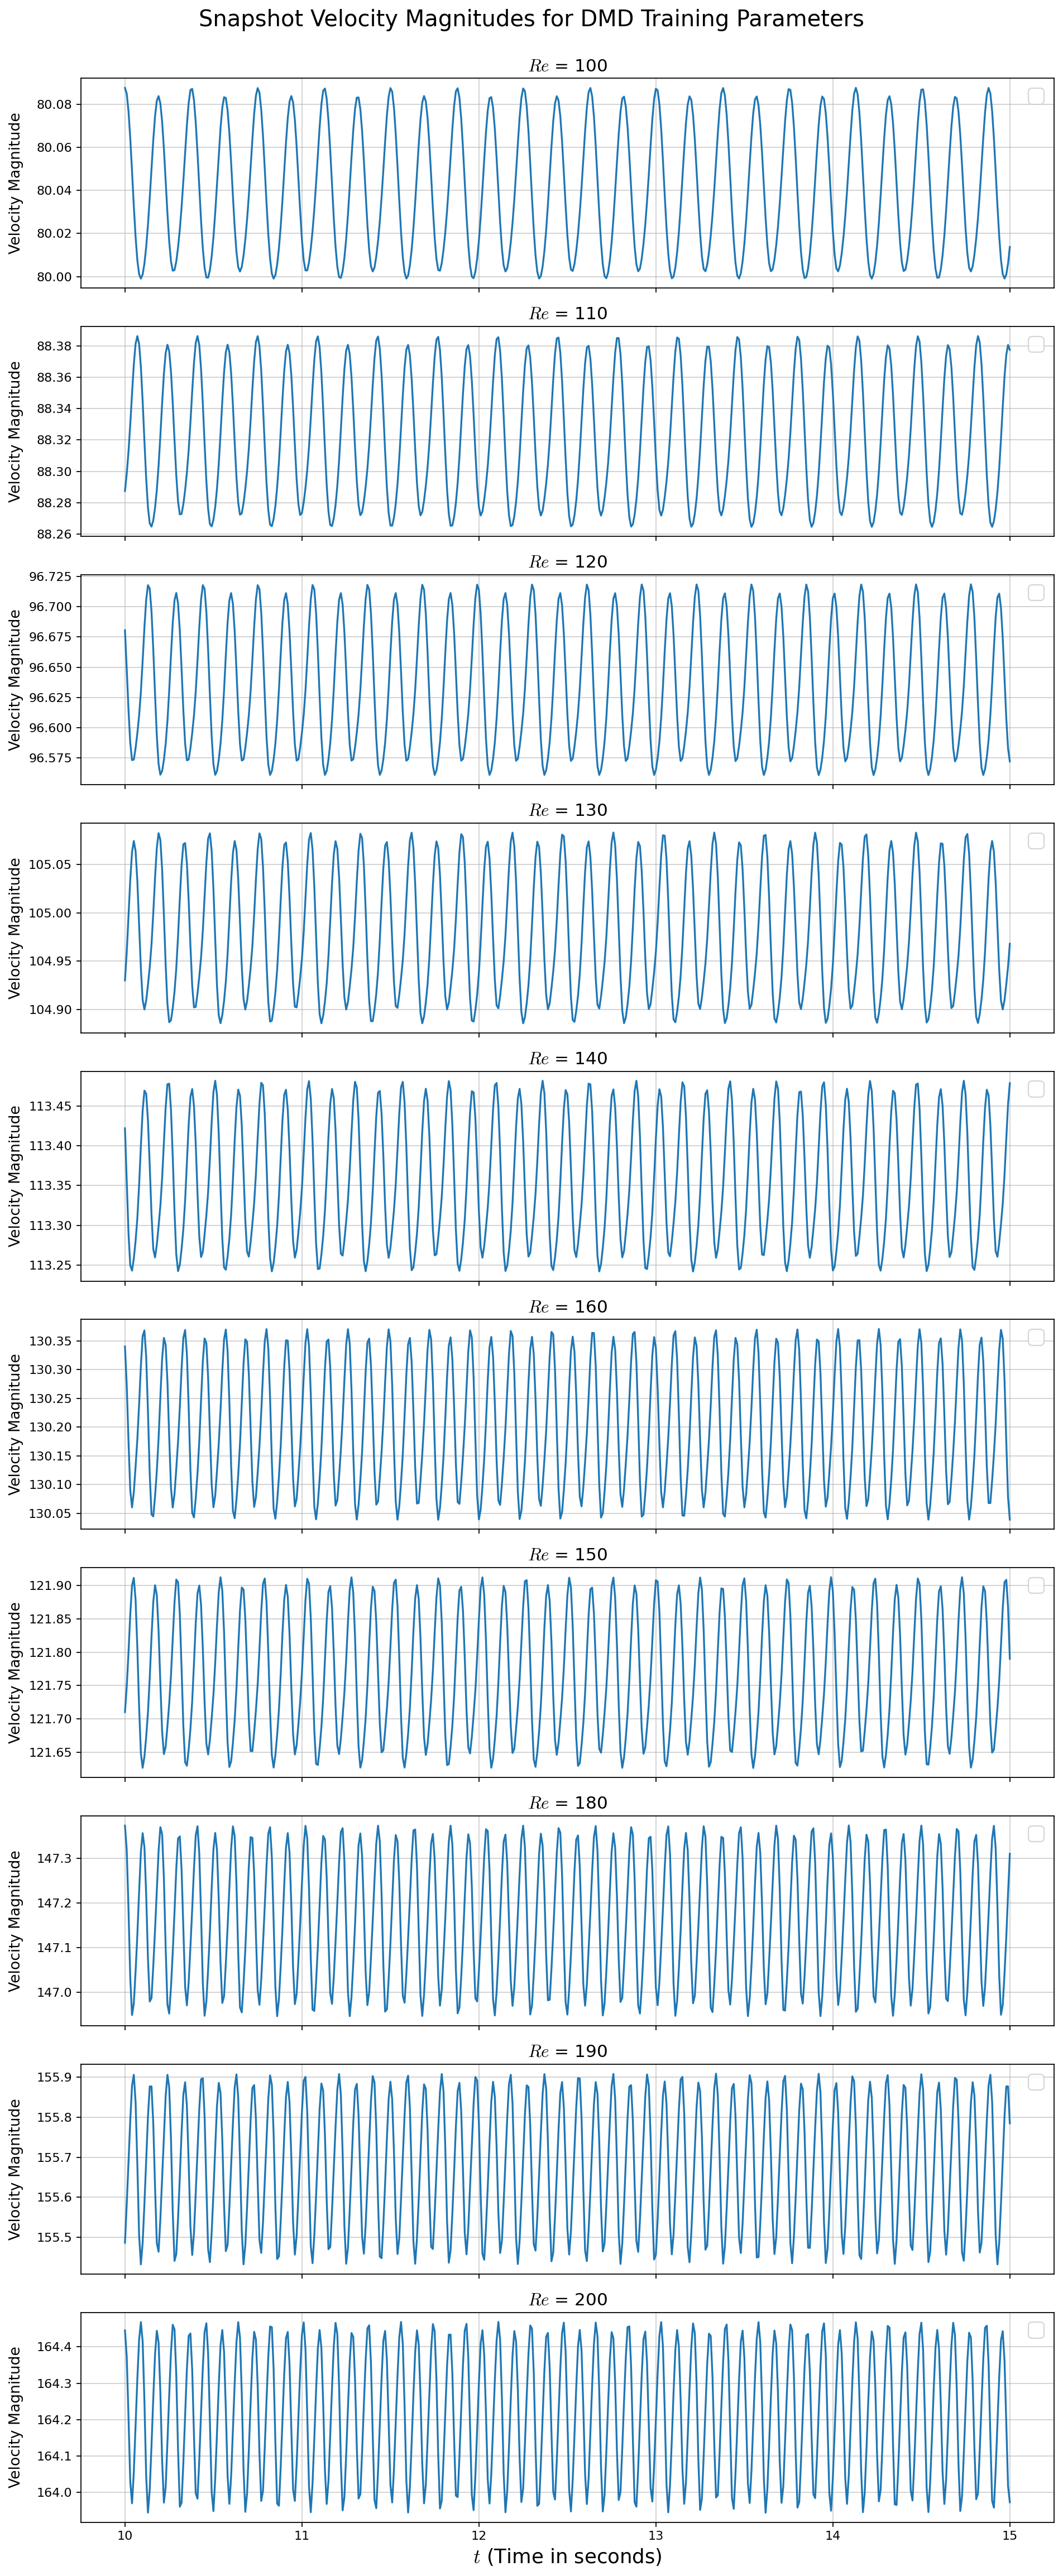

In [6]:
# Snapshot magnitude over time for each Parameter i.e., Reynolds number

from visualization_utilities import plot_snapshot_magnitudes

loader_dict = data["loader_dict"]  

plot_snapshot_magnitudes(snapshot_dict, sampled_times_dict, Re_list)


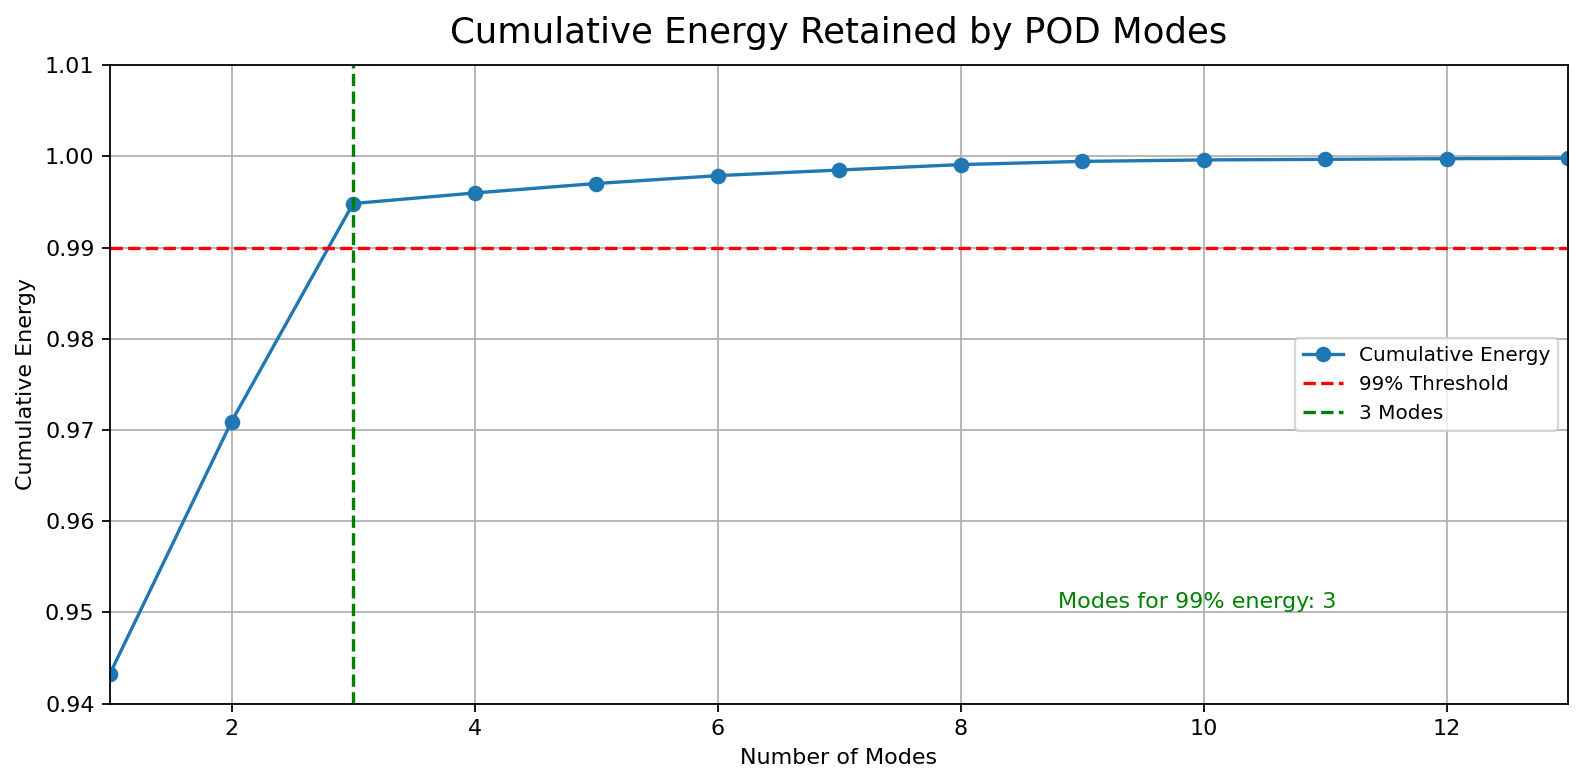

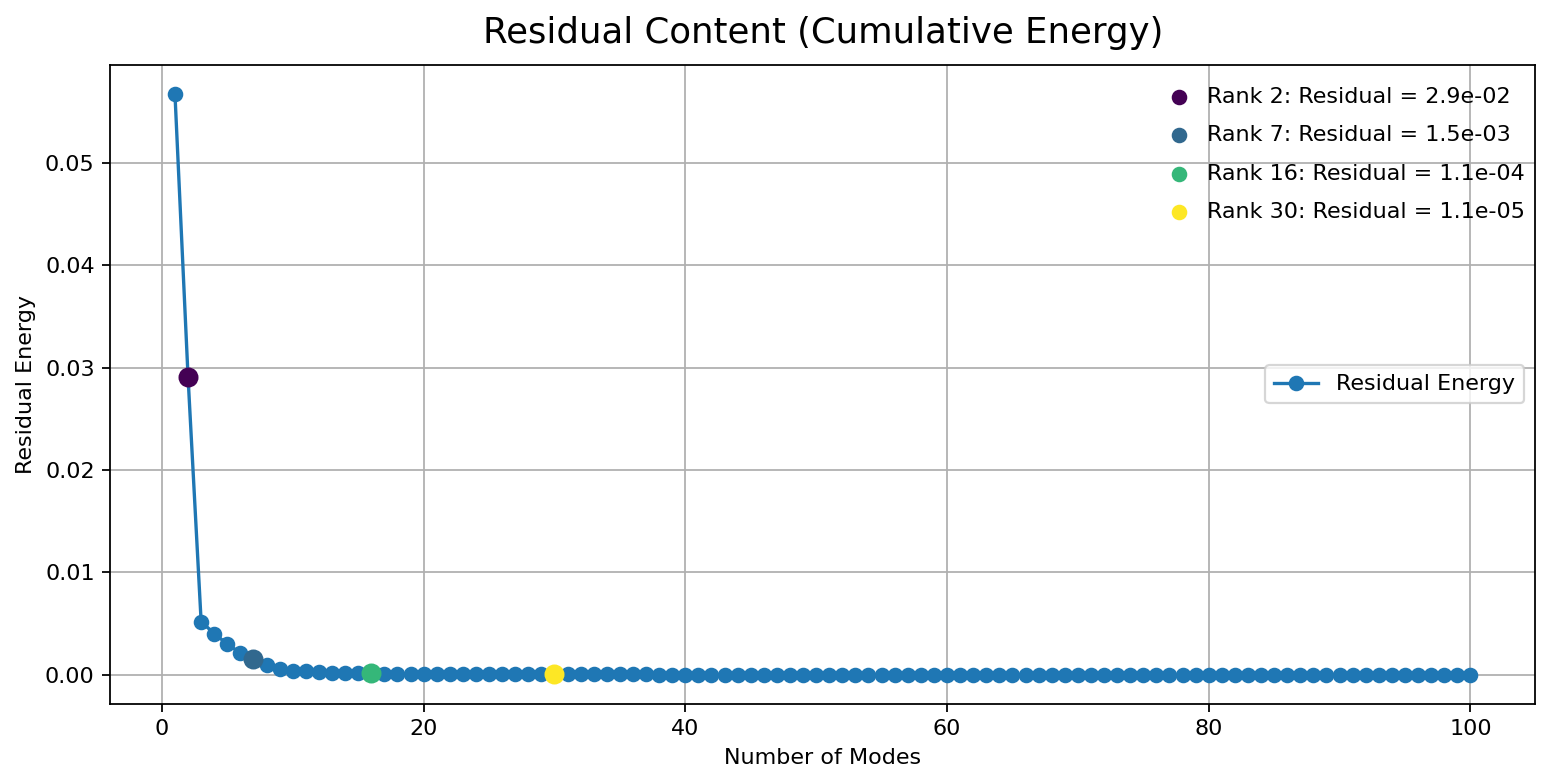

In [7]:
# Plot POD cummulative energy residuals analysis for the training snapshots

from visualization_utilities import compute_pod, get_thresholds, plot_cumulative_energy, plot_residual_energy


# Compute POD energy and residuals
cumulative_energy, residual_content = compute_pod(snapshot_dict, Re_list)

tau_list = [1e-2, 1e-3, 1e-4, 1e-5]

# Get ranks for your specified tau thresholds
num_modes_99, tau_ranks = get_thresholds(residual_content, threshold=0.99, tau_list=tau_list)

# Plot cumulative energy with zoom
plot_cumulative_energy(cumulative_energy, threshold=0.99, num_modes_99=num_modes_99)

# Plot residual energy with colored summary
plot_residual_energy(residual_content, tau_ranks)


## Partitioned ParametericDMD from PyDMD 

#### References

[Ichinaga et al., *PyDMD: A Python Package for Robust Dynamic Mode Decomposition*, JMLR 2024 — GitHub](https://github.com/mathLab/PyDMD)




## Offline Phase

## Step 1: Perform POD and DMD on the concatenated snapshot matrix X1

In [8]:
# POD and Parameteric DMD

# Step 1: Create shared POD basis
rom = POD(rank=30, method="randomized_svd")

# Step 2: Create DMD instances
trained_dmds = [DMD(svd_rank=-1) for _ in Re_list]

# Step 3: Create interpolator
interpolator = RBF()

# Step 4: Construct ParametricDMD
pdmd = ParametricDMD(trained_dmds, rom, interpolator)

# Step 6: Fit model
pdmd.fit(train_snapshots, np.array(Re_list).reshape(-1, 1))


/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 1732892.6958702165. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
INFO:root:Snapshots: (30, 501), snapshot shape: (30,)
/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 1034113.4440734203. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
INFO:root:Snapshots: (30, 501), snapshot shape: (30,)
/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 404554.3621233115. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
INFO:root:Snapshots: (30, 501), snapshot shape: (30,)
/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snap

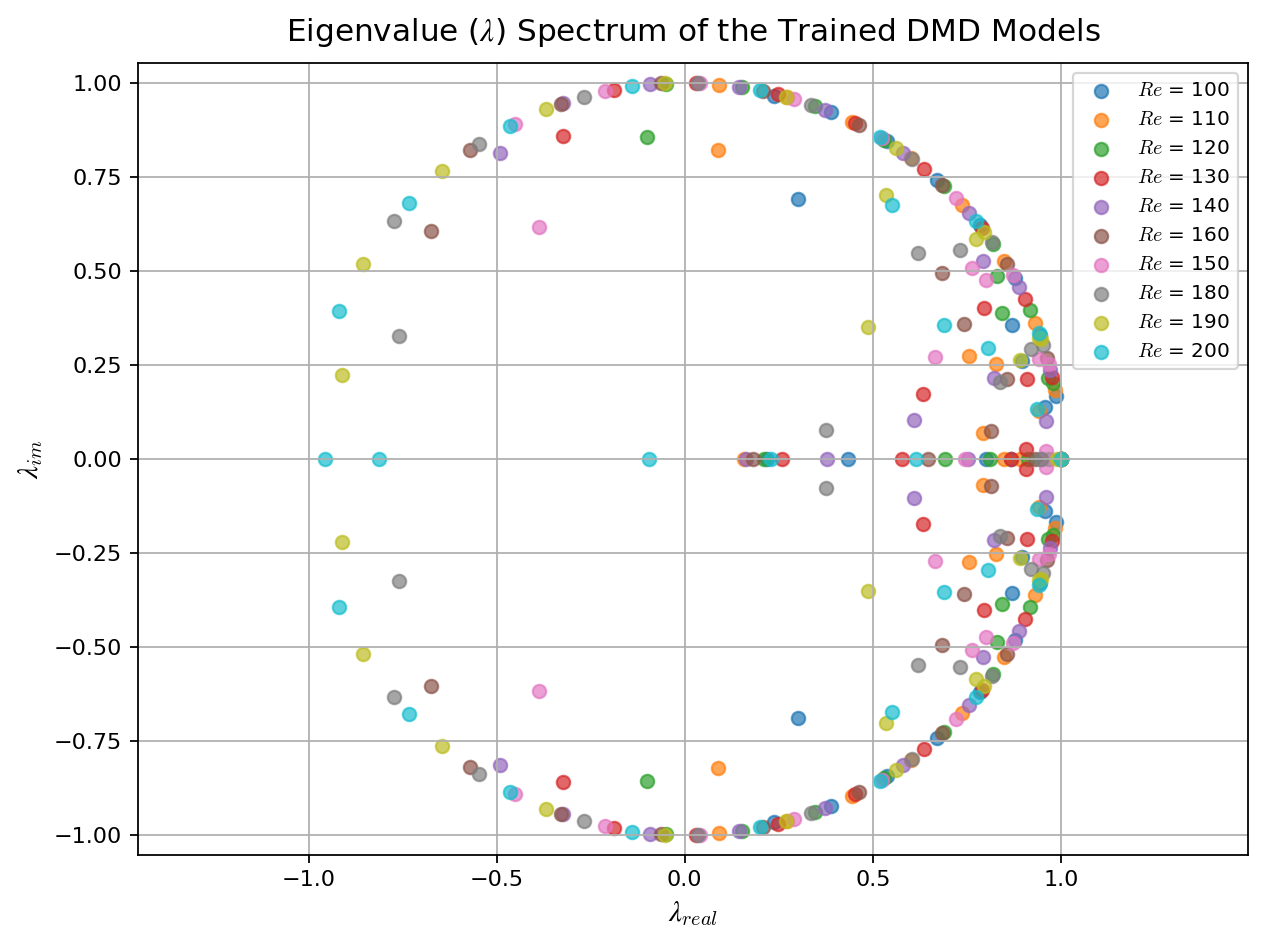

In [9]:
# Visualize eigenvalue spectrum of trained DMD models

plt.figure(figsize=(8, 6))

for i, dmd in enumerate(pdmd._dmd):
    eigs = dmd.eigs
    Re = Re_list[i]
    plt.scatter(np.real(eigs), np.imag(eigs), label=f"$Re$ = {Re}", alpha=0.7)

plt.xlabel("$λ_{real}$", fontsize=13)
plt.ylabel("$λ_{im}$", fontsize=13)
plt.title("Eigenvalue ($λ$) Spectrum of the Trained DMD Models", fontsize=14, pad=10)
plt.grid(True)
plt.axis("equal")
plt.legend(loc="best", fontsize=9)
plt.tight_layout()
plt.show()

/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


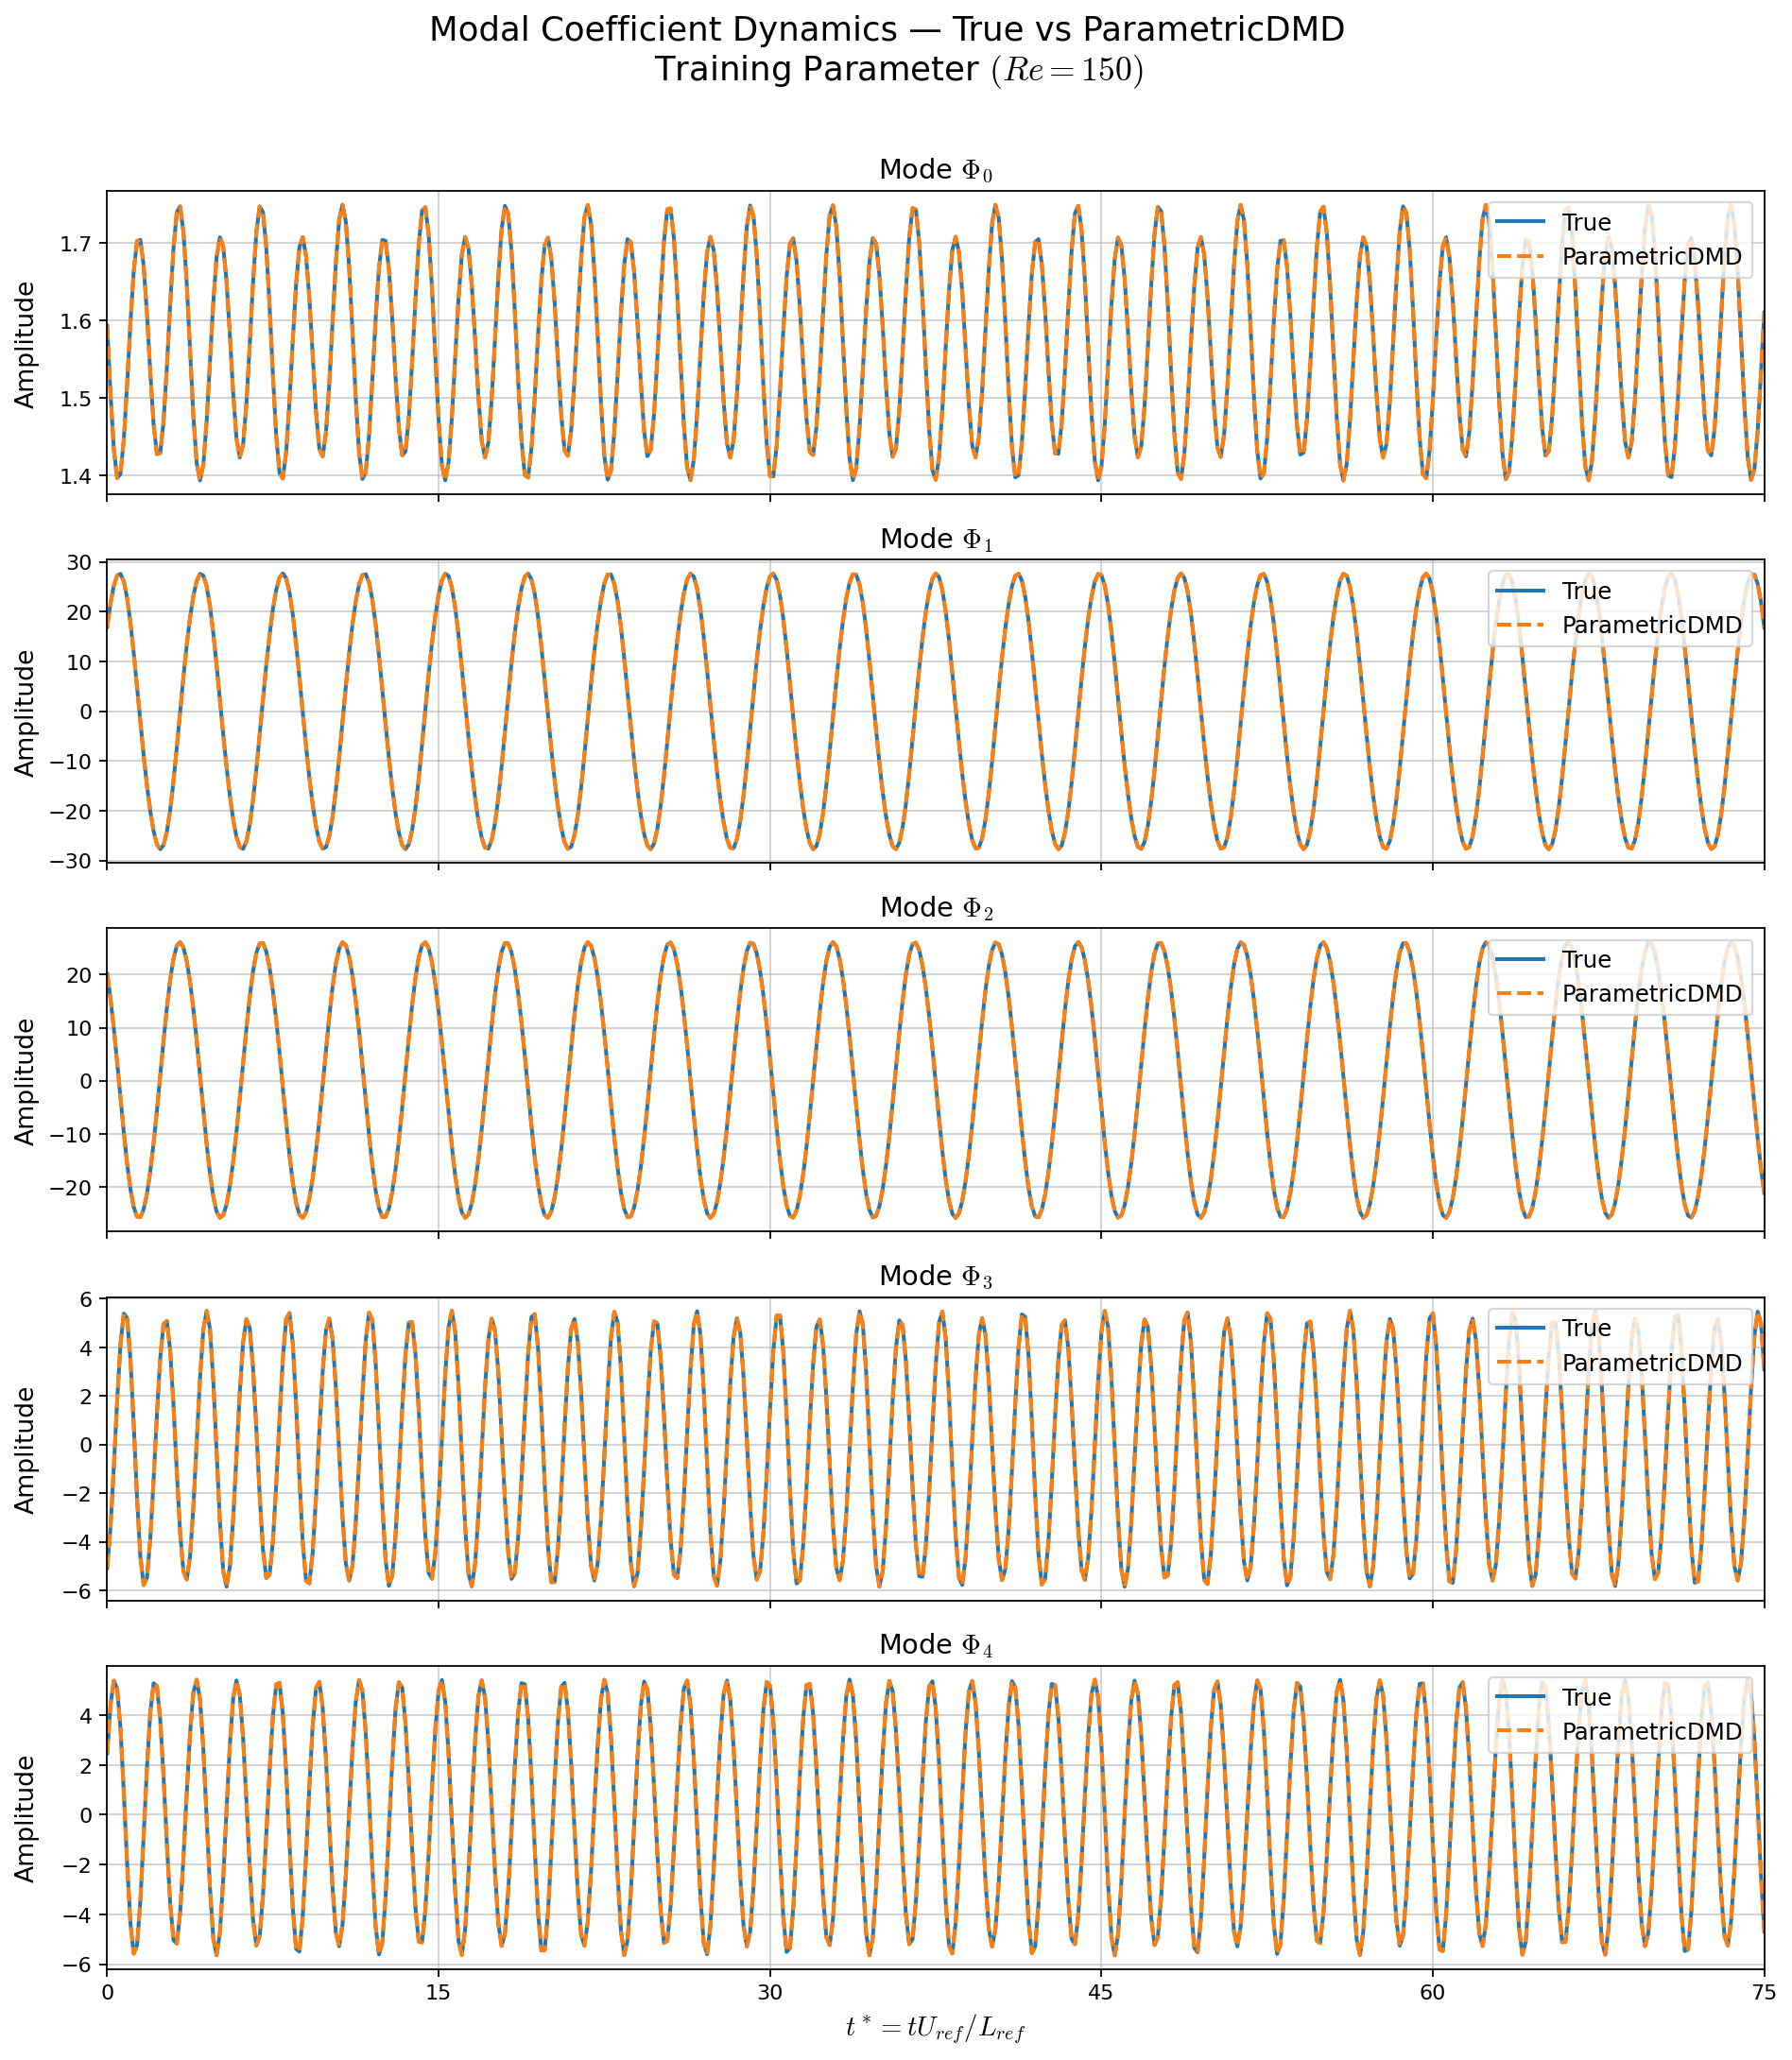

In [10]:
# Plot comparison of DMD modal coefficients for training Parameters i.e., Reynolds numbers

from visualization_utilities import plot_dmd_modal_comparison

Re_target = 150

plot_dmd_modal_comparison(
    pdmd=pdmd,
    Re_list=Re_list,
    sampled_times_dict=sampled_times_dict,
    Re_value=Re_target,
    U_ref_dict=U_ref_dict,
    L_ref=L_ref,
    n_modes_to_plot=5
)



/home/haseeb/Notebooks/Parametric_DMD_cylinder_2D_modules/visualization_utilities.py:227: ComplexWarning: Casting complex values to real discards the imaginary part
  modal_dmd_clean = np.asarray(modal_dmd[mode], dtype=np.float64)


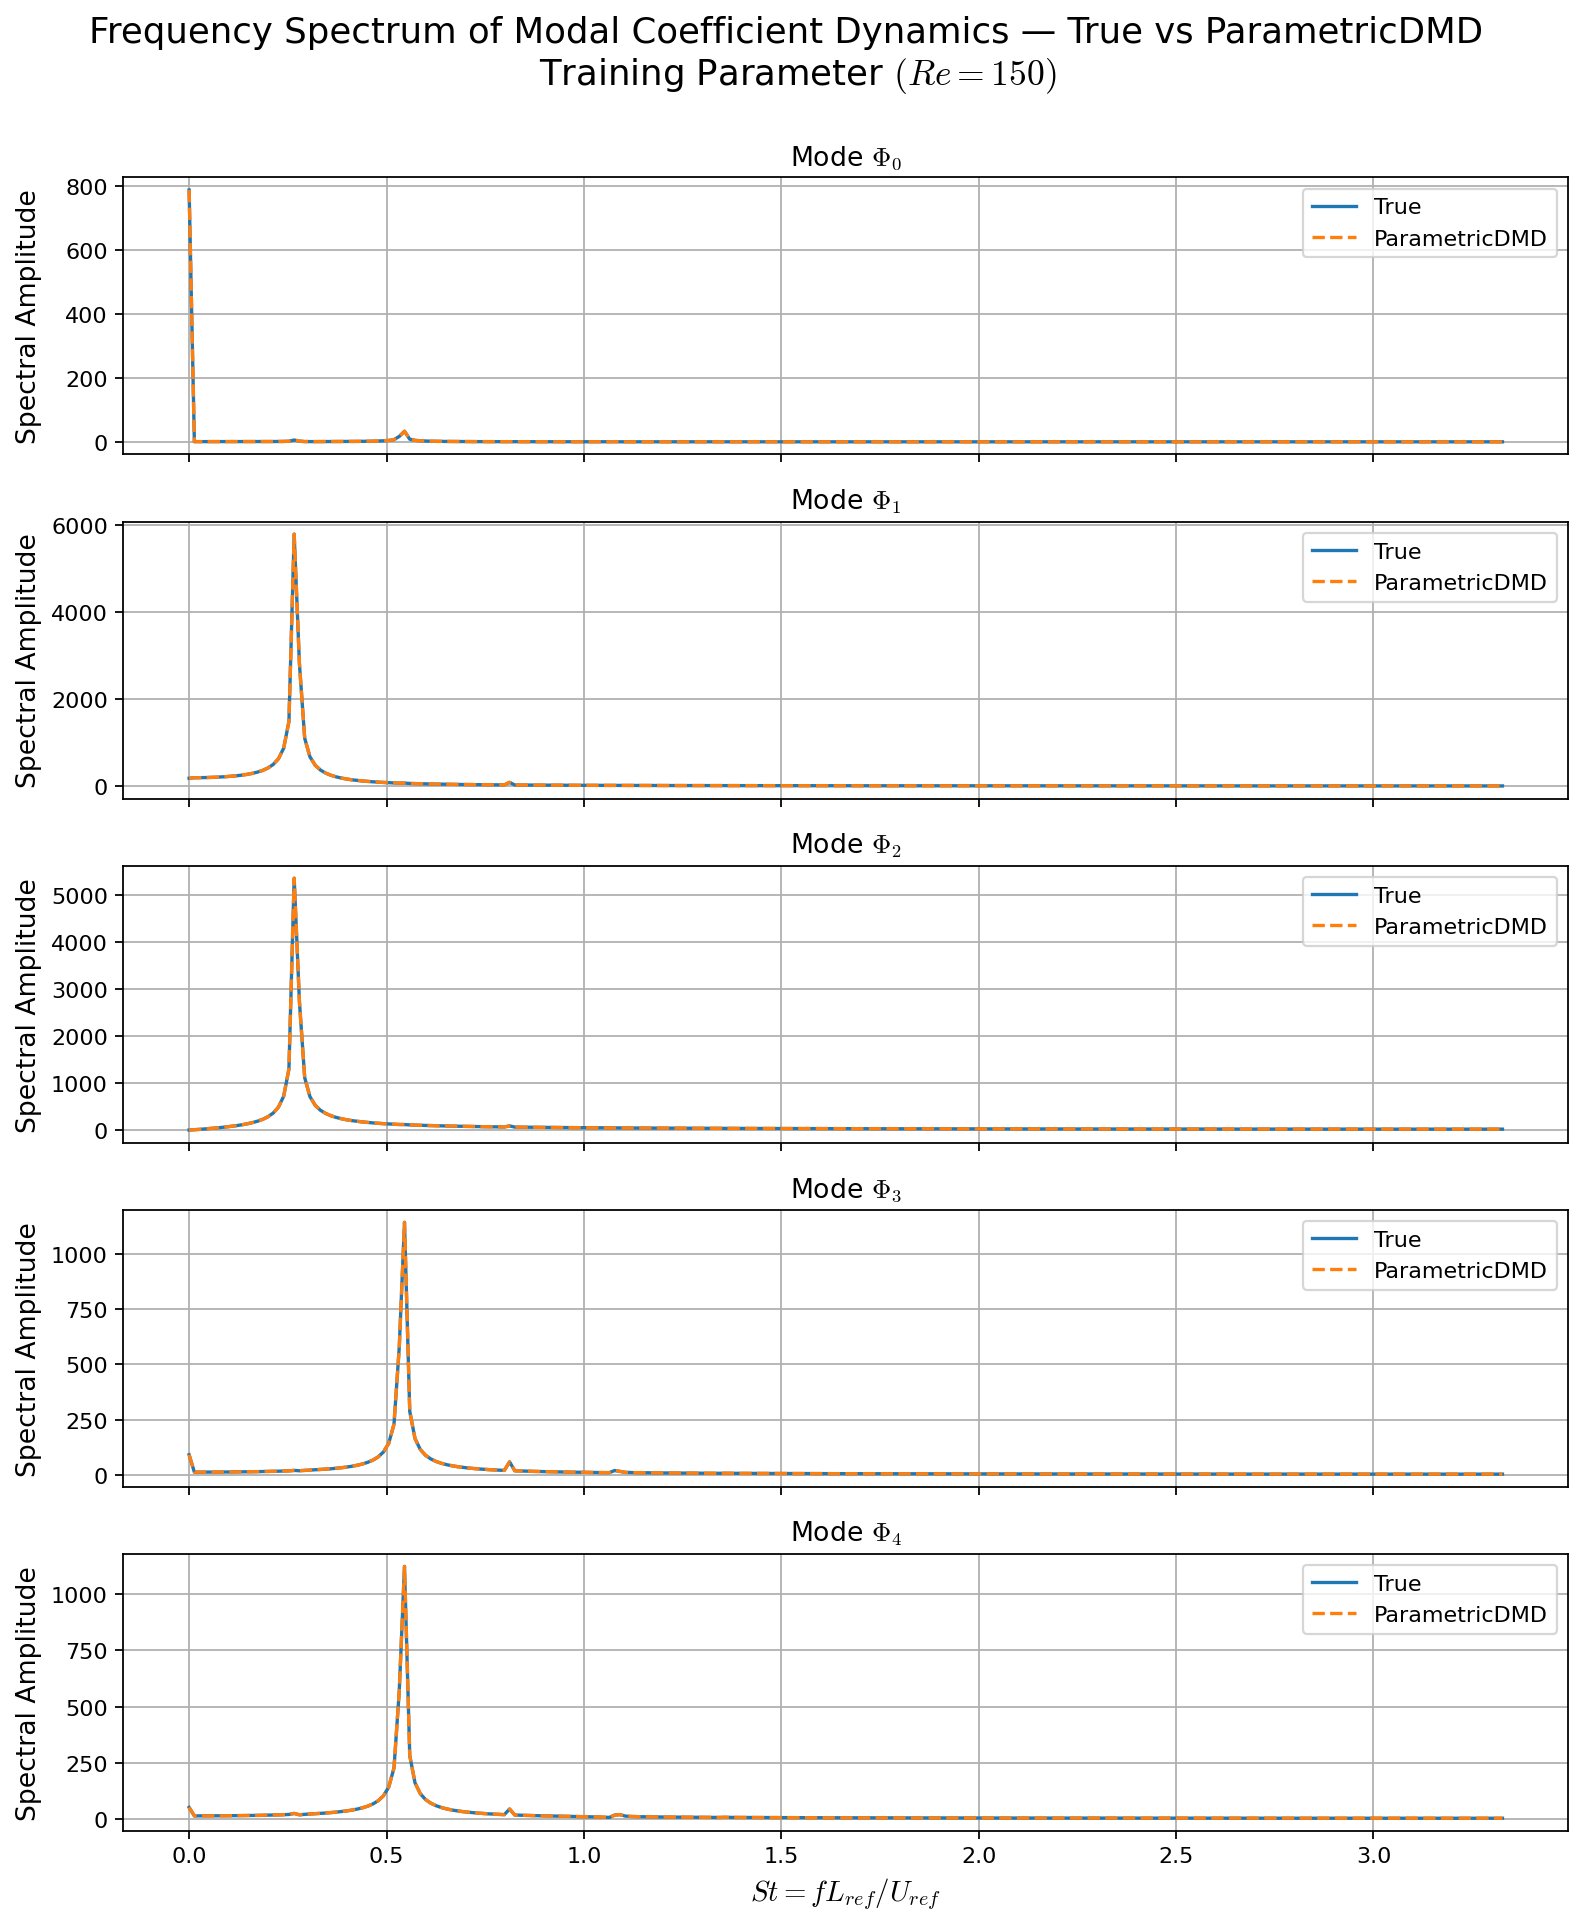

In [11]:
# Plot comparison of DMD modal coefficients FFT for training Parameters i.e., Reynolds numbers


from visualization_utilities import plot_dmd_fft_comparison

Re_target = 150 # Reynolds number to inspect

n_plot = 5  # Number of DMD modes to include in the FFT plots

dt = 0.01

plot_dmd_fft_comparison(
    pdmd=pdmd,
    Re_list=Re_list,
    Re_target=Re_target,
    L_ref=L_ref,
    nu=nu,
    n_plot=n_plot,   
    dt=dt
)



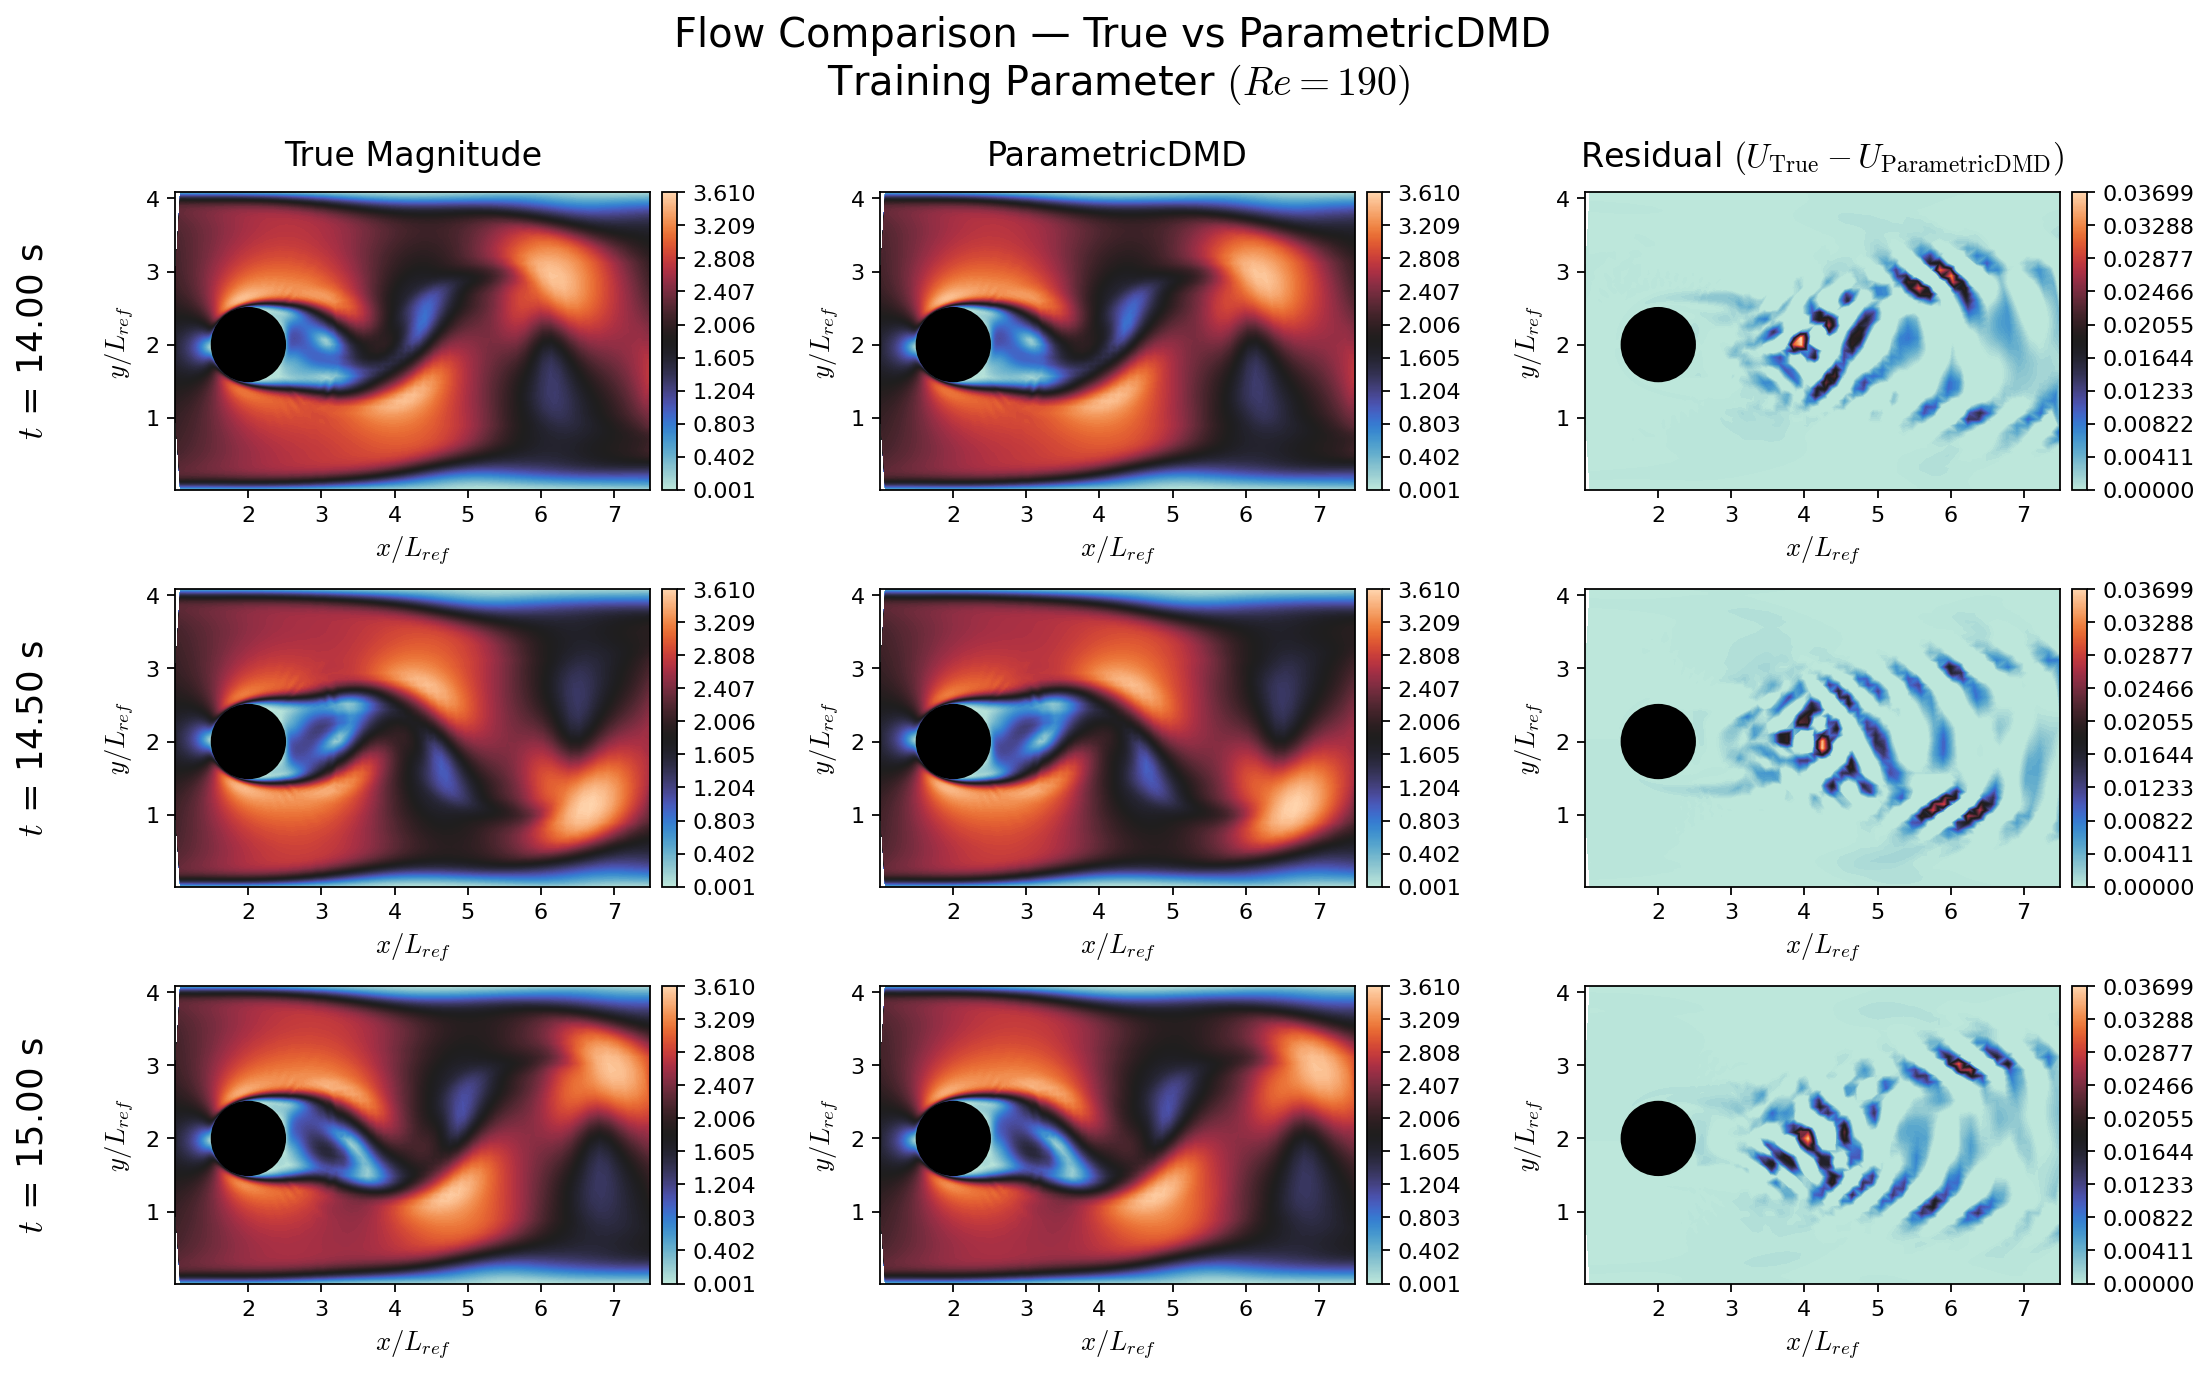

In [12]:
# Plot flow comparison for training Parameters i.e., Reynolds numbers


from visualization_utilities import plot_flow_comparison_dmd_vs_true

# Set target Reynolds number and time range
Re_target = 190
t_start = 14.0
t_end = 15.0
granularity = 0.5

# Plot flow comparison between DMD prediction and true simulation
plot_flow_comparison_dmd_vs_true(
    Re_target=Re_target,
    Re_list=Re_list,
    t_start=t_start,
    t_end=t_end,
    granularity=granularity,
    rom=rom,
    pdmd=pdmd,
    mean_flow=mean_flow_train,
    sampled_times_dict=sampled_times_dict,
    snapshot_processed_dict=snapshot_processed_dict,
    masked_coords_dict=masked_coords_dict,
    num_points_dict=num_points_dict,
    L_ref=L_ref,
    cylinderX=cylinderX,
    cylinderY=cylinderY,
    radius=radius,
    cmap='icefire'
)




In [13]:
# 🔒 Cache trained DMD internals before interpolation
cached_dmd_list = pdmd._dmd.copy()  # List of trained DMD instances
cached_modal_coeffs = pdmd.training_modal_coefficients.copy()  # List of modal coefficient arrays



/home/haseeb/Notebooks/Parametric_DMD_cylinder_2D_modules/visualization_utilities.py:411: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


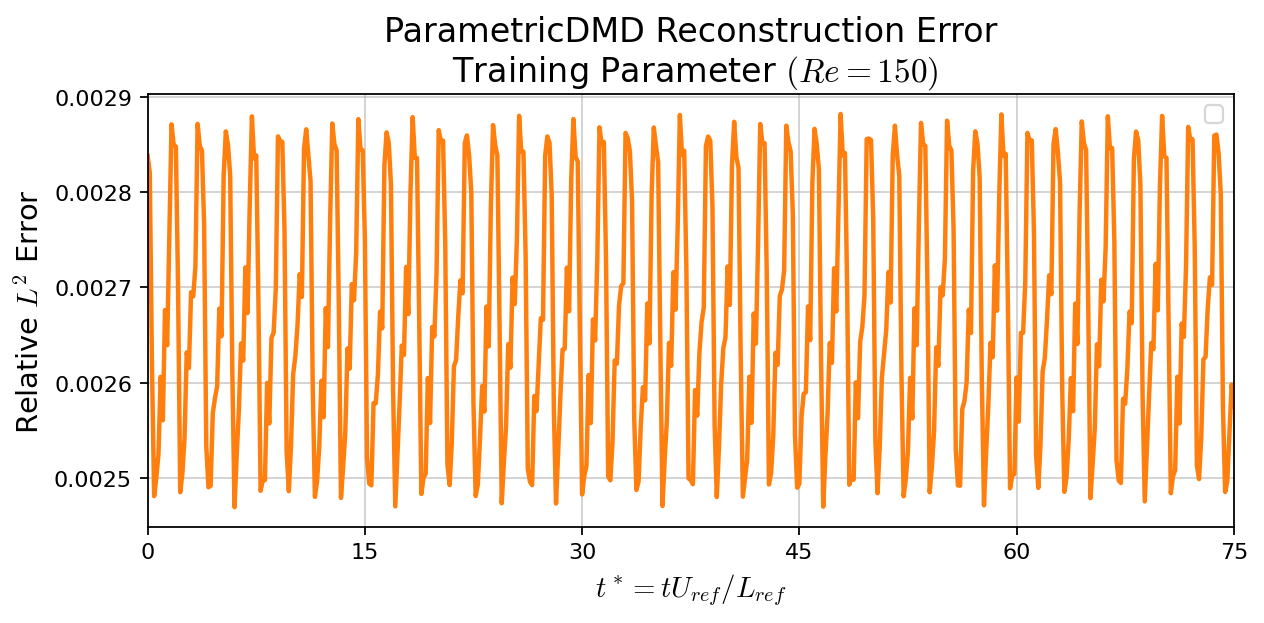

In [14]:
# Plot ParametricDMD reconstruction error for training parameter i.e., Reynolds numbers

from visualization_utilities import plot_dmd_reconstruction_error

plot_dmd_reconstruction_error(
    Re_target=150,
    Re_list=Re_list,
    rom=rom,
    pdmd=pdmd,
    mean_flow_train=mean_flow_train,
    sampled_times_dict=sampled_times_dict,
    snapshot_processed_dict=snapshot_processed_dict,
    L_ref=L_ref,      # reference length (e.g. cylinder diameter)
    nu=nu,        # kinematic viscosity
    color='tab:orange'
)






# Online phase

# Forecasting and interpolation for unknown Re

In [15]:
# Define forecasting time range

# Use sampled times from the first Re in your training list
training_times = np.array(sampled_times_dict[Re_list[0]], dtype=float)

pdmd.dmd_time["t0"]   = pdmd.original_time["tend"] 
pdmd.dmd_time["tend"] = pdmd.original_time["tend"] + 500 - 1e-12
pdmd.dmd_time["dt"]   = pdmd.original_time["dt"]


# Set target Re for interpolation
pdmd.parameters = np.array([[150]])


# Trigger reconstruction (includes forecasting)
forecasted_snapshots = pdmd.reconstructed_data  # shape: (1, space_dim, time_steps)
forecasted_field = forecasted_snapshots[0]

# Print physical time steps
print(
    f"Forecasting from t = {pdmd.dmd_time['t0']} to t = {pdmd.dmd_time['tend']} with Δt = {pdmd.dmd_time['dt']}"
)
print("Time vector:", pdmd.dmd_timesteps)



Forecasting from t = 500 to t = 999.999999999999 with Δt = 1
Time vector: [ 500.  501.  502.  503.  504.  505.  506.  507.  508.  509.  510.  511.
  512.  513.  514.  515.  516.  517.  518.  519.  520.  521.  522.  523.
  524.  525.  526.  527.  528.  529.  530.  531.  532.  533.  534.  535.
  536.  537.  538.  539.  540.  541.  542.  543.  544.  545.  546.  547.
  548.  549.  550.  551.  552.  553.  554.  555.  556.  557.  558.  559.
  560.  561.  562.  563.  564.  565.  566.  567.  568.  569.  570.  571.
  572.  573.  574.  575.  576.  577.  578.  579.  580.  581.  582.  583.
  584.  585.  586.  587.  588.  589.  590.  591.  592.  593.  594.  595.
  596.  597.  598.  599.  600.  601.  602.  603.  604.  605.  606.  607.
  608.  609.  610.  611.  612.  613.  614.  615.  616.  617.  618.  619.
  620.  621.  622.  623.  624.  625.  626.  627.  628.  629.  630.  631.
  632.  633.  634.  635.  636.  637.  638.  639.  640.  641.  642.  643.
  644.  645.  646.  647.  648.  649.  650.  651.  

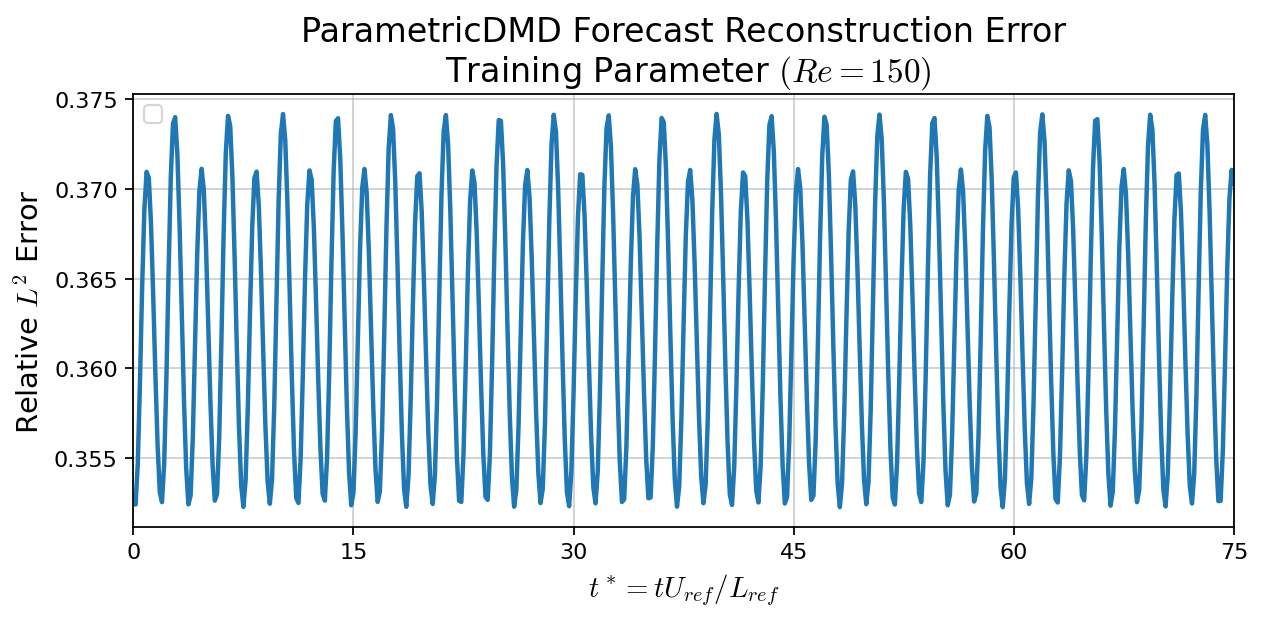

In [21]:
# Plot ParametricDMD forecast reconstruction error for training Parameters i.e., Reynolds numbers

from visualization_utilities import plot_dmd_forecast_error

plot_dmd_forecast_error(
    Re_target=150,
    Re_list=Re_list,
    rom=rom,
    pdmd=pdmd,
    mean_flow_train=mean_flow_train,
    sampled_times_dict=sampled_times_dict,
    snapshot_processed_dict=snapshot_processed_dict,
    L_ref=L_ref,
    nu=nu,
    color='tab:blue'
)


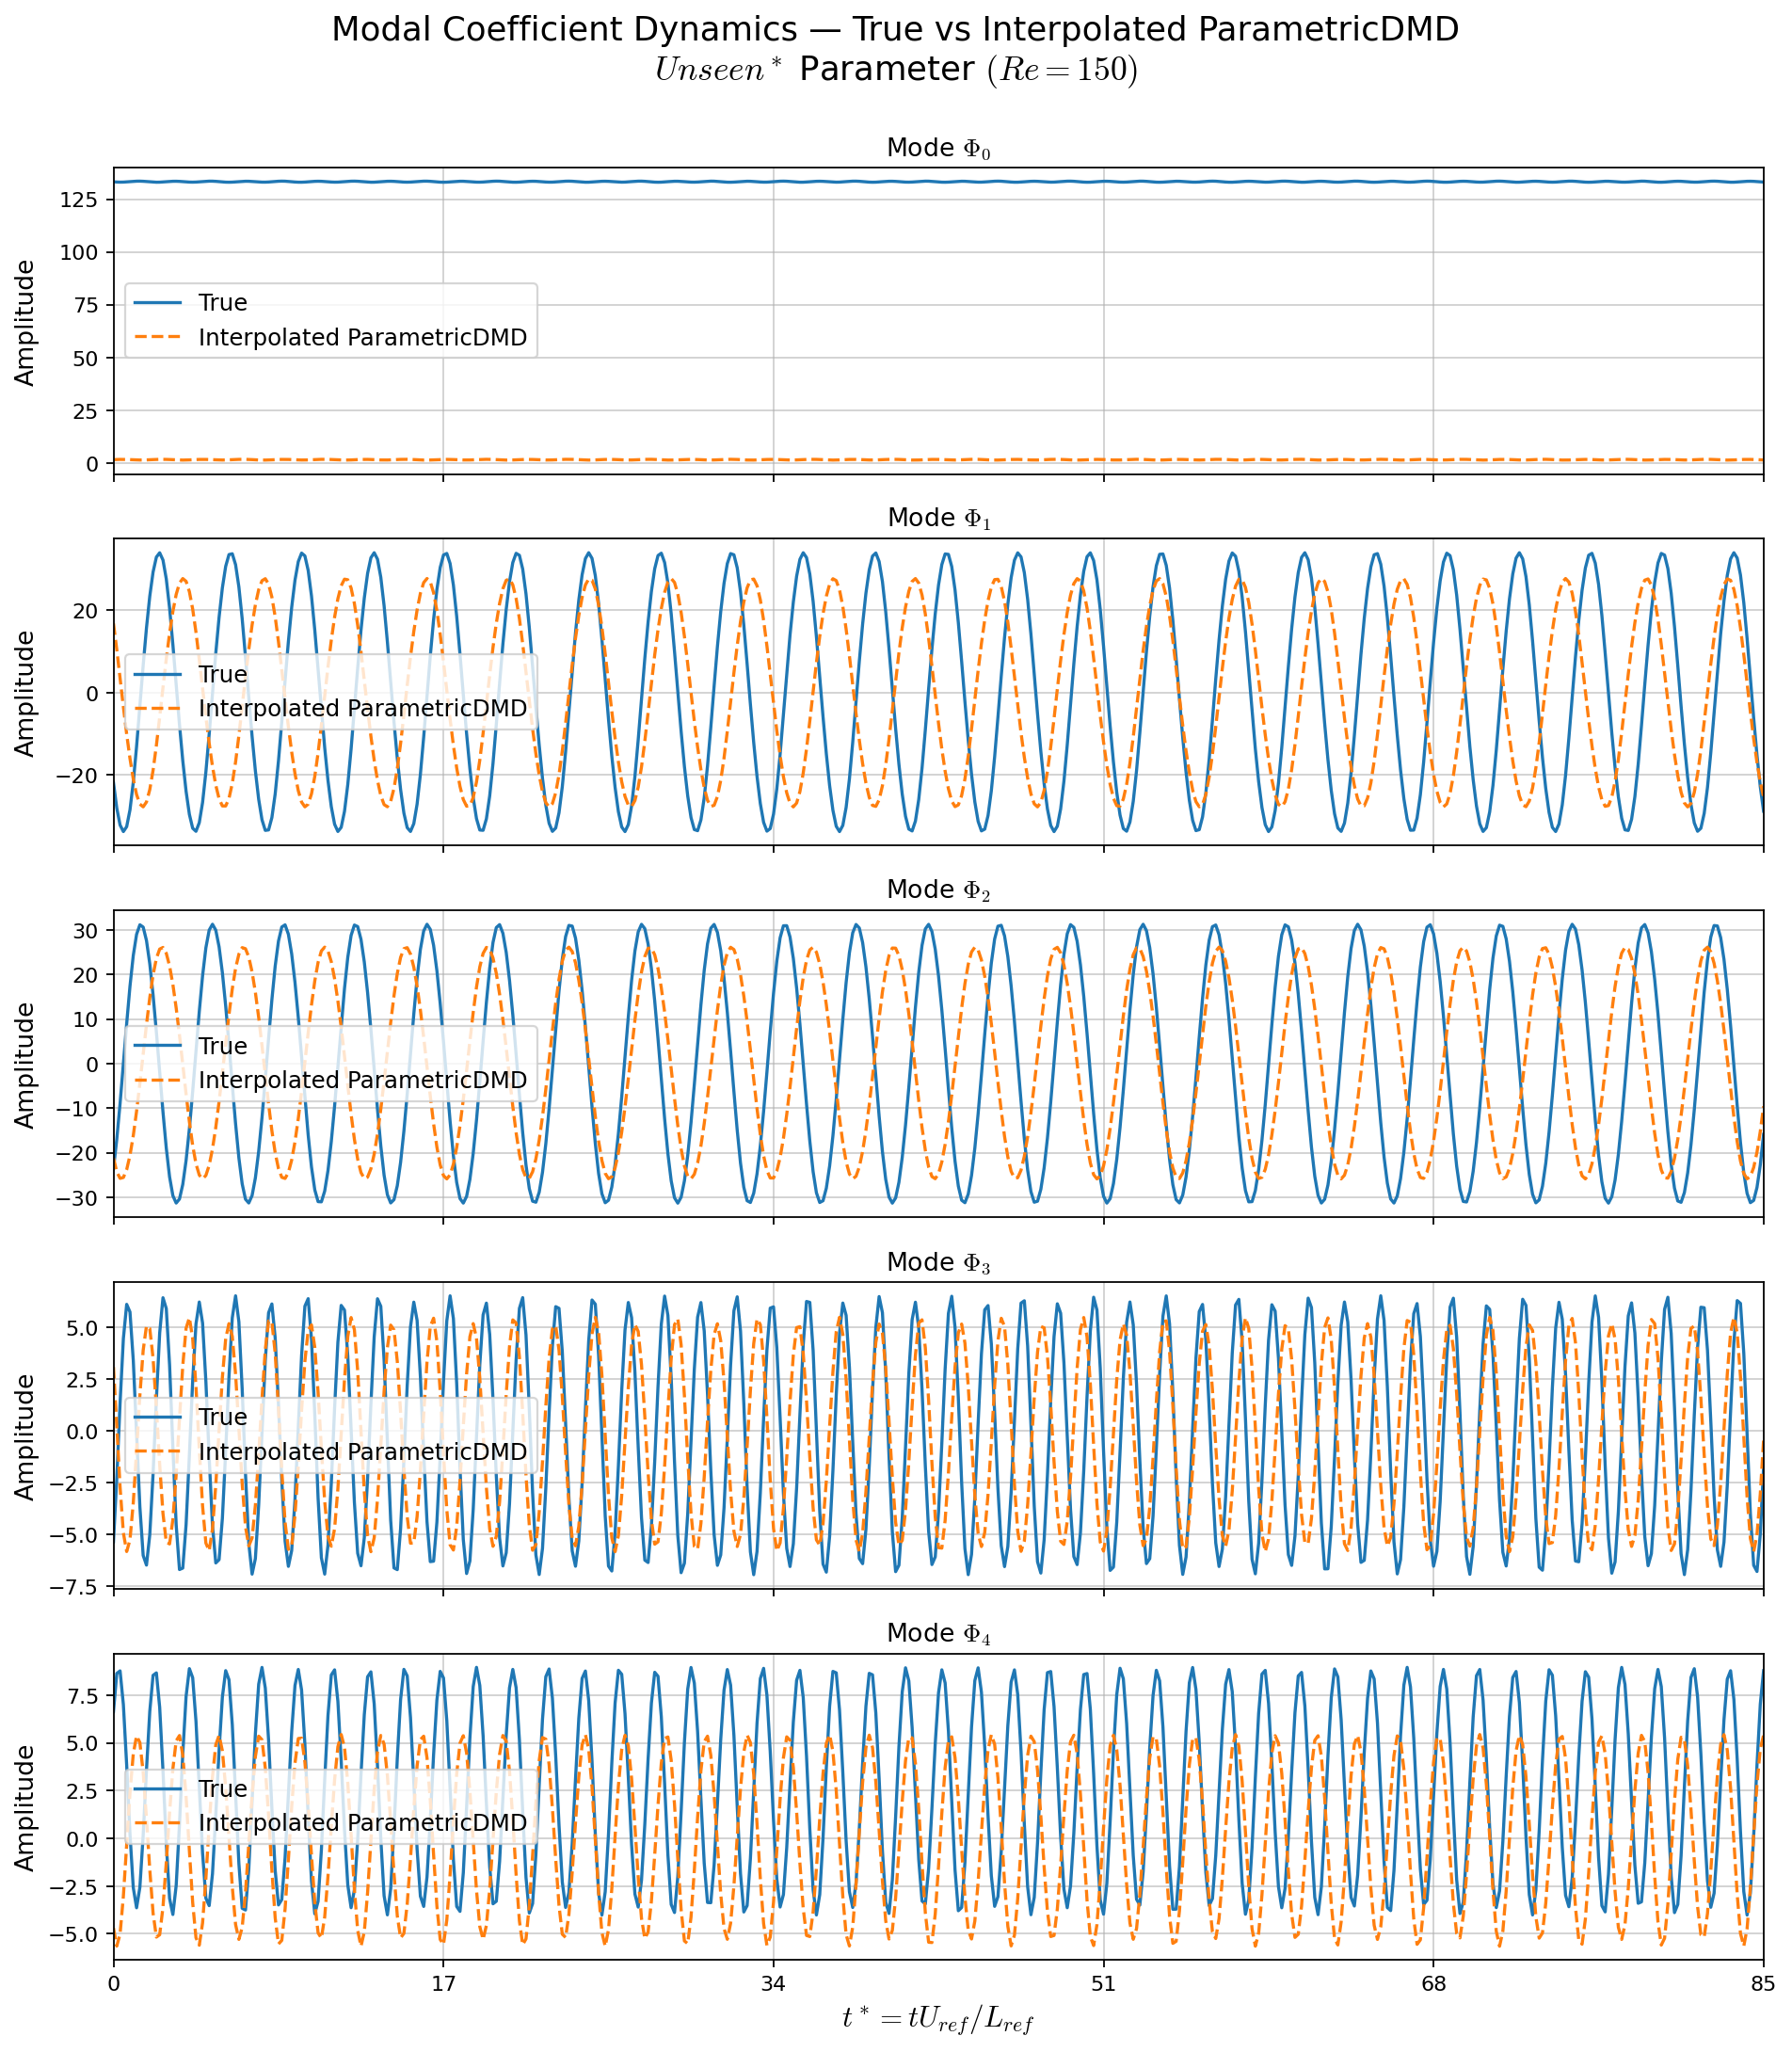

In [17]:
# Plot comparison of interpolated DMD modal coefficients for unseen Parameter i.e., Reynolds numbers


from visualization_utilities import plot_dmd_modal_comparison_interp_vs_true

# Number of DMD modes to visualize
n_modes_to_plot = 5

plot_dmd_modal_comparison_interp_vs_true(
    pdmd=pdmd,
    snapshot_test=snapshot_test,
    loader_test=loader_test,
    Re_test=Re_test,
    dt_phys=0.01,
    t0_phys=15.0,
    n_modes_to_plot=n_modes_to_plot,
    L_ref=L_ref,
    nu=nu,
    time_window=(3.0, 20.0) 
)




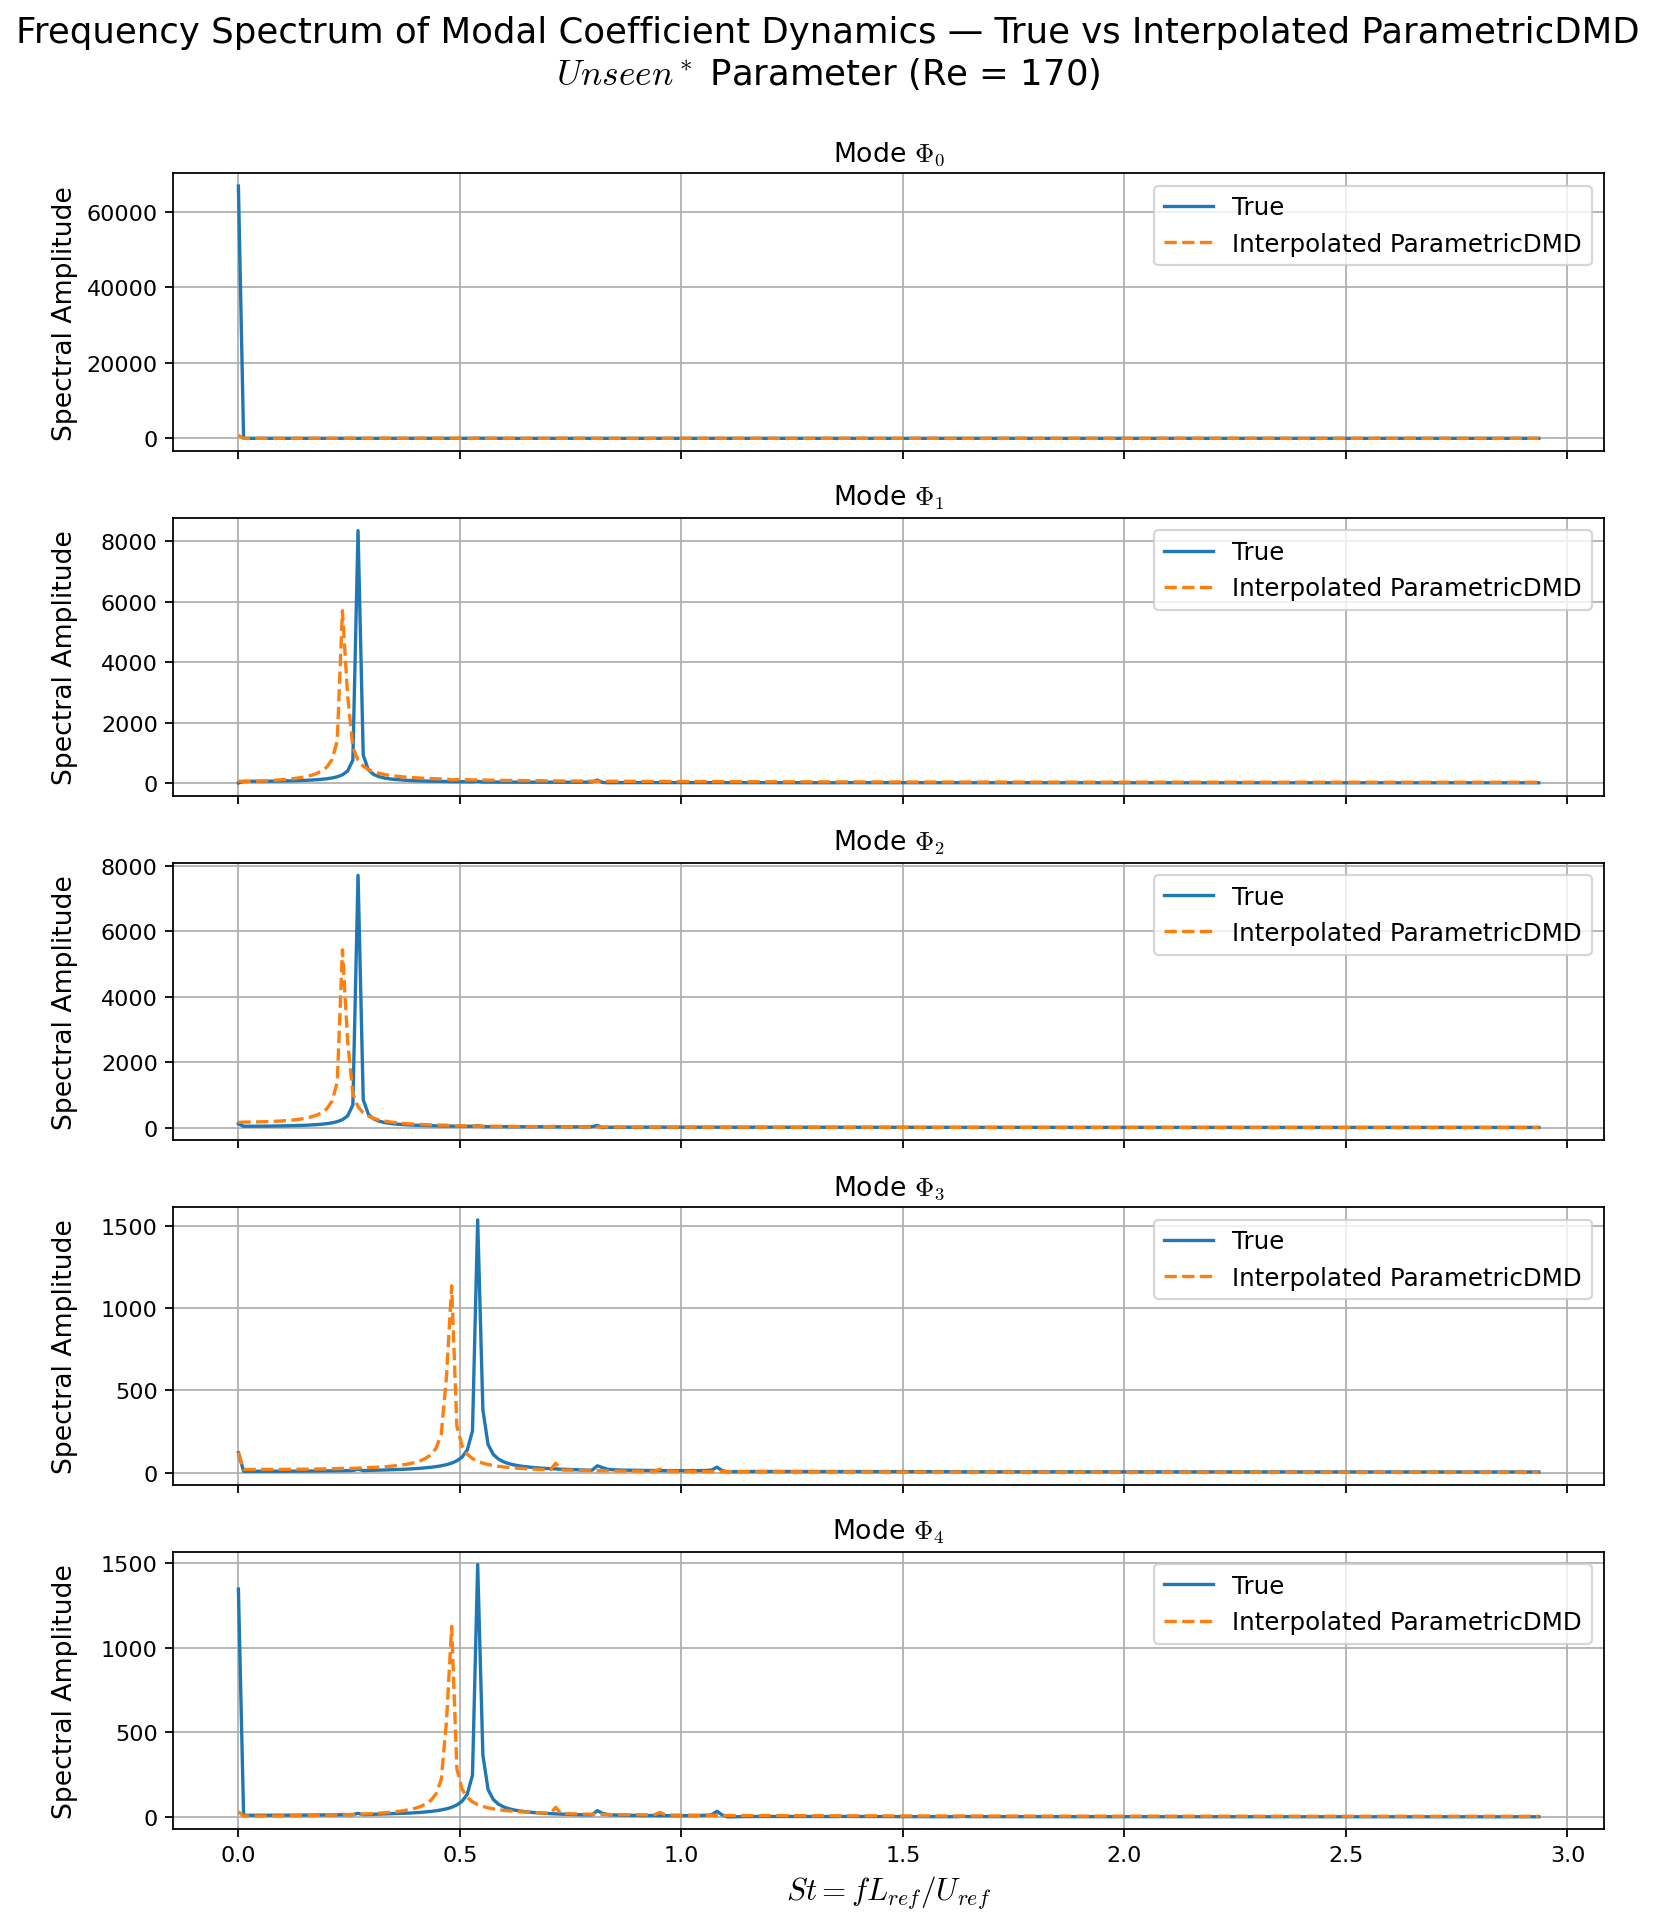

In [18]:
# Plot comparison of interpolated modal coefficients FFT for unseen parameter i.e., Reynolds numbers

from visualization_utilities import plot_fft_modal_comparison_interp_vs_true


plot_fft_modal_comparison_interp_vs_true(
    pdmd=pdmd,
    snapshot_test=snapshot_test,
    loader_test=loader_test,
    Re_test=Re_test,
    dt_phys=0.01,
    t0_phys=15.0,
    n_modes_to_plot=5,
    match_tolerance=0.05,
    L_ref=L_ref,
    nu=nu
)



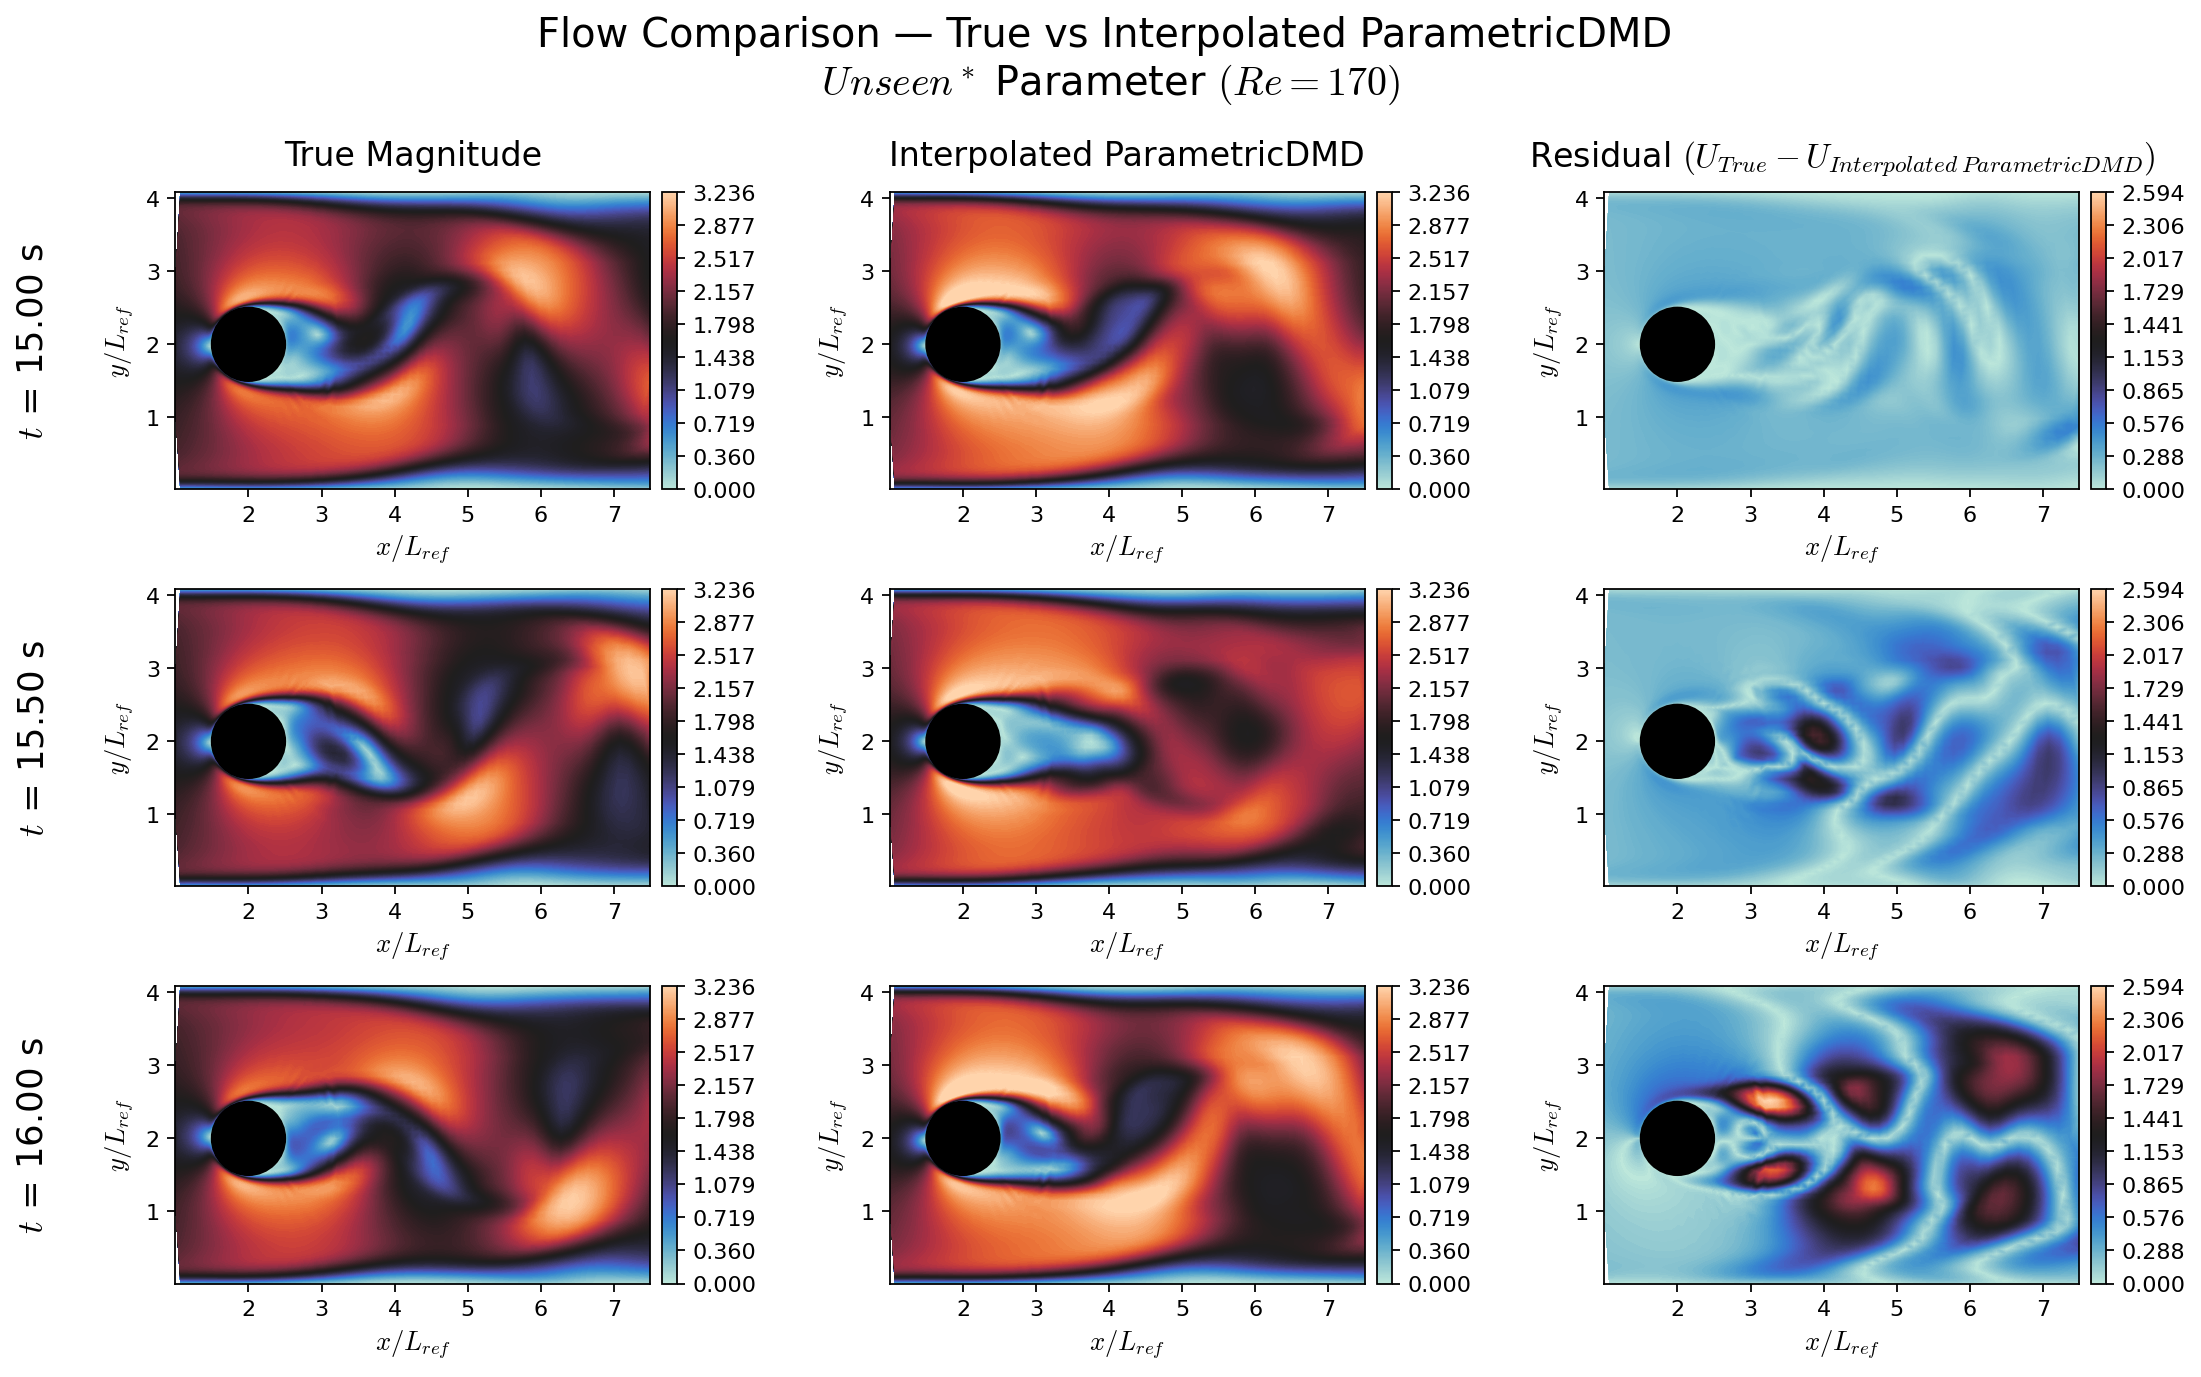

In [19]:
# Plot flow comparison for interpolated DMD for unseen parameter i.e., Reynolds number
from visualization_utilities import plot_flow_comparison_interpolated_dmd_vs_true

t_start = 15.0
t_end = 16.0
granularity = 0.5
plot_flow_comparison_interpolated_dmd_vs_true(
    pdmd=pdmd,
    snapshot_test=snapshot_test,
    sampled_times_test=times_test,
    loader_test=loader_test, 
    mask_test=mask_test,
    num_points_test=num_points_test,
    mean_flow_test=mean_flow_test,
    Re_test=Re_test,
    t_start=t_start,
    t_end=t_end,
    granularity=granularity,
    L_ref=0.1,
    cmap="icefire"
)



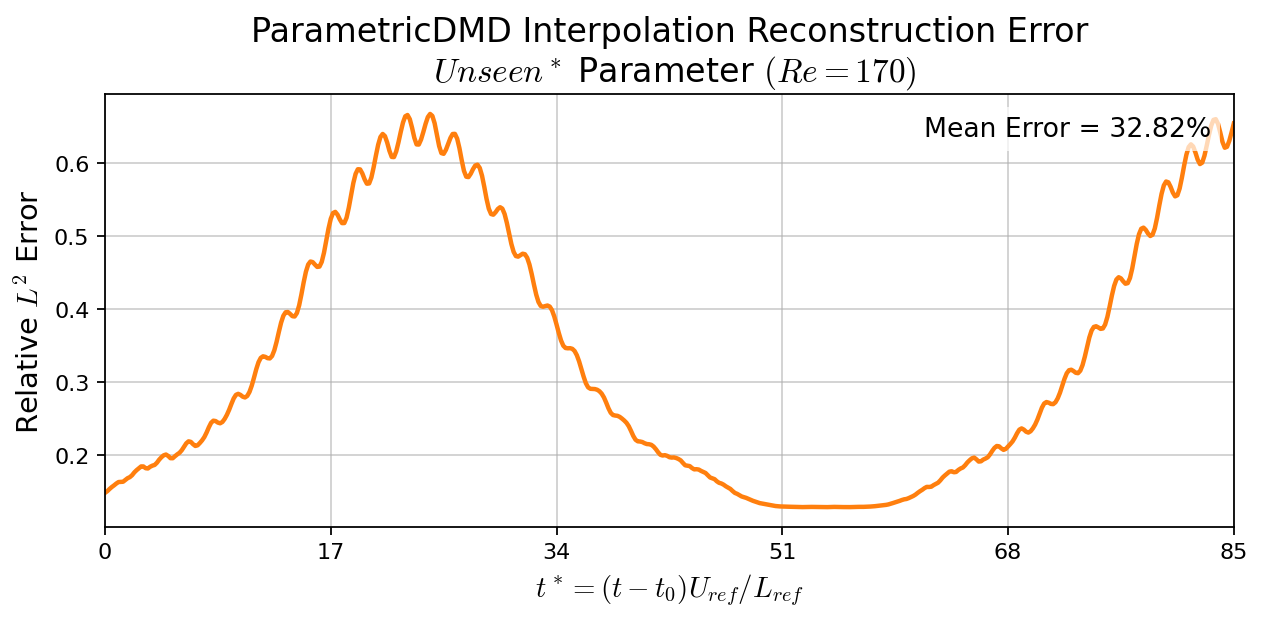

In [20]:
# Plot interpolation reconstruction error unseen parameter i.e., Reynolds number

from visualization_utilities import plot_interp_reconstruction_error

plot_interp_reconstruction_error(
    snapshot_test,
    times_test,
    pdmd,
    dt_phys=0.01,
    Re_test=Re_test,
    mean_flow_test=mean_flow_test,
    nu=nu,
    L_ref=L_ref
)
